# Exploracion del dataset

Nota: Por cada grupo de de salida (en este caso solo tenemos gatos o perros, vamos a establecer un conjunto de prueba y y uno de validacion)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Obtener las rutas del dataset

In [3]:
base_dir = f'/content/drive/Othercomputers/BISITE/Desktop/dataset'

In [4]:
train_dir = f'{base_dir}/train'
validation_dir = f'{base_dir}/validation'

In [5]:
train_dir_alambra = f'{train_dir}/Alambra'
validation_dir_alambra = f'{validation_dir}/Alambra'

In [6]:
train_dir_coronita = f'{train_dir}/Coronita'
validation_dir_coronita = f'{validation_dir}/Coronita'

In [7]:
train_dir_mahou = f'{train_dir}/Mahou'
validation_dir_mahou = f'{validation_dir}/Mahou'

### Listar los ficheros en cada directorio

In [8]:
train_files_alambra = os.listdir(train_dir_alambra)
train_files_coronita = os.listdir(train_dir_coronita)
train_files_mahou = os.listdir(train_dir_mahou)
validation_files_alambra = os.listdir(validation_dir_alambra)
validation_files_coronita = os.listdir(validation_dir_coronita)
validation_files_mahou = os.listdir(validation_dir_mahou)

### Imprimir informacion del dataset

In [9]:
print(f'Number of train alambra files: {len(train_files_alambra)}')
print(f'Number of validation alambra files: {len(validation_files_alambra)}')
print(f'Number of train coronita files: {len(train_files_coronita)}')
print(f'Number of validation coronita files: {len(validation_files_coronita)}')
print(f'Number of train mahou files: {len(train_files_mahou)}')
print(f'Number of validation mahou files: {len(validation_files_alambra)}')

random_file = f'{train_dir_coronita}/{random.choice(train_files_coronita)}'
print(f'Example files: {random_file}')

Number of train alambra files: 100
Number of validation alambra files: 28
Number of train coronita files: 100
Number of validation coronita files: 32
Number of train mahou files: 100
Number of validation mahou files: 28
Example files: /content/drive/Othercomputers/BISITE/Desktop/dataset/train/Coronita/IMG_6624.JPG


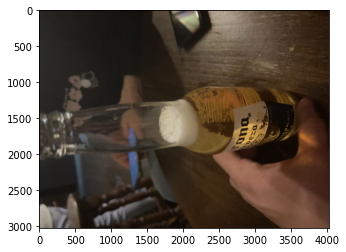

In [10]:
img = mpimg.imread(random_file)
plt.imshow(img)

# Construir el modelo

### Definicion del modelo por capas

In [11]:
import tensorflow as tf

In [12]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    
    # FC hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Compilar modelo

In [14]:
from tensorflow.keras.optimizers import RMSprop

In [15]:
model.compile(
    optimizer='rmsprop'
    , loss = 'categorical_crossentropy'
    , metrics = ['accuracy']
)

# Preprocesamiento de las imagenes

Vamos a construir un datagen, que es un iterador de imagenes.

### Construimos unos generadores de prueba **SIN** data augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# esto son descriptores de como modificar la imagen, con estos construimos el generador como tal
train_datagen_with_no_data_augmentation = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen_with_no_data_augmentation = ImageDataGenerator(rescale = 1.0/255.0)

### Construimos unos generadores (definitivos) **CON** data augmentation

In [18]:
# esto son descriptores de como modificar la imagen, con estos construimos el generador como tal
train_datagen_with_data_augmentation = ImageDataGenerator(
      rescale=1.0/255
      , rotation_range = 40
      , width_shift_range = 0.2
      , height_shift_range = 0.2
      , shear_range = 0.2
      , zoom_range = 0.2
      , horizontal_flip = True
      , fill_mode = 'nearest'
)
test_datagen_with_data_augmentation = ImageDataGenerator(
    rescale = 1.0/255.0
)

### Ahora con estos, construimos el generador como tal

In [19]:
train_generator = train_datagen_with_data_augmentation.flow_from_directory(
    train_dir
    , batch_size=20
    , class_mode='categorical'
    , target_size=(150,150)
)
test_generator = test_datagen_with_data_augmentation.flow_from_directory(
    validation_dir
    , batch_size=20
    , class_mode='categorical'
    , target_size=(150,150)
)

Found 300 images belonging to 3 classes.
Found 92 images belonging to 3 classes.


# Entrenamiento del modelo

### Entrenar el modelo

In [20]:
history = model.fit(
    train_generator
    , steps_per_epoch=10
    , epochs=10
    , validation_data=test_generator
    , validation_steps=3
    , verbose=2
)

Epoch 1/10
10/10 - 189s - loss: 1.4427 - accuracy: 0.3500 - val_loss: 1.0785 - val_accuracy: 0.2667 - 189s/epoch - 19s/step
Epoch 2/10
10/10 - 105s - loss: 1.0684 - accuracy: 0.3550 - val_loss: 1.0222 - val_accuracy: 0.6500 - 105s/epoch - 11s/step
Epoch 3/10
10/10 - 90s - loss: 1.6880 - accuracy: 0.5650 - val_loss: 0.9218 - val_accuracy: 0.6833 - 90s/epoch - 9s/step
Epoch 4/10
10/10 - 79s - loss: 0.7748 - accuracy: 0.7000 - val_loss: 0.4991 - val_accuracy: 0.7167 - 79s/epoch - 8s/step
Epoch 5/10
10/10 - 79s - loss: 0.8201 - accuracy: 0.7000 - val_loss: 0.5623 - val_accuracy: 0.9833 - 79s/epoch - 8s/step
Epoch 6/10
10/10 - 80s - loss: 0.5108 - accuracy: 0.8300 - val_loss: 0.3862 - val_accuracy: 0.8667 - 80s/epoch - 8s/step
Epoch 7/10
10/10 - 83s - loss: 0.9944 - accuracy: 0.8250 - val_loss: 0.3765 - val_accuracy: 0.9500 - 83s/epoch - 8s/step
Epoch 8/10
10/10 - 82s - loss: 0.2378 - accuracy: 0.9700 - val_loss: 0.3900 - val_accuracy: 0.8000 - 82s/epoch - 8s/step
Epoch 9/10
10/10 - 83s - l

### Graficar el proceso de entrenamiento

In [21]:
accuracy_training = history.history['accuracy']
accuracy_validation = history.history['val_accuracy']
loss_training = history.history['loss']
loss_validation = history.history['val_loss']
epochs = range(len(accuracy_training))

<Figure size 432x288 with 0 Axes>

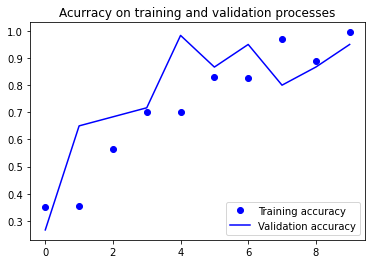

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(epochs, accuracy_training, 'bo', label='Training accuracy')
plt.plot(epochs, accuracy_validation, 'b', label='Validation accuracy')
plt.title('Acurracy on training and validation processes')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

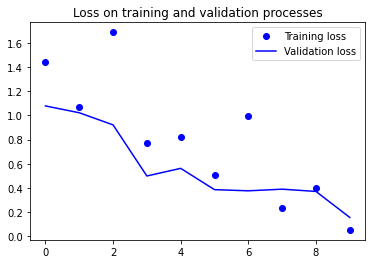

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(epochs, loss_training, 'bo', label='Training loss')
plt.plot(epochs, loss_validation, 'b', label='Validation loss')
plt.title('Loss on training and validation processes')
plt.legend()
plt.figure()

### Probar modelo

In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image

##Alambra

Cargamos la imagen para pintarla

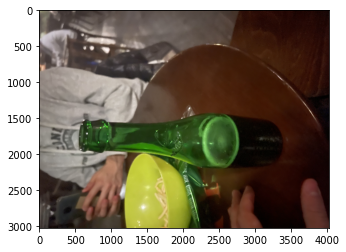

In [25]:
test_img_path = f'{validation_dir_alambra}/{random.choice(validation_files_alambra)}'
img = mpimg.imread(test_img_path)
plt.imshow(img)

Cargamos la imagen para meterla en la red neuronal

In [26]:
test_img = image.load_img(test_img_path, target_size=(150,150))
x = image.img_to_array(test_img)
x = np.expand_dims(x, axis=0)
cnn_input_image = np.vstack([x])

In [27]:
result = model.predict(cnn_input_image, batch_size=10)
result

1/1 [==============================] - 0s 160ms/step


array([[1., 0., 0.]], dtype=float32)

In [28]:
mappings = {
    0: 'alambra'
    , 1: 'coronita'
    , 2: 'mahou'
}
normalize_result = lambda result, mappings: mappings[np.argmax(result)]
result = normalize_result(result, mappings)
print(f'La imagen contiene una cerveza {result}')

La imagen contiene una cerveza alambra


##Coronita

Cargamos la imagen para pintarla

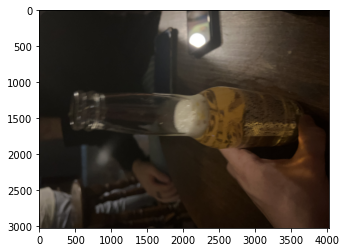

In [29]:
test_img_path = f'{validation_dir_coronita}/{random.choice(validation_files_coronita)}'
img = mpimg.imread(test_img_path)
plt.imshow(img)

Cargamos la imagen para meterla en la red neuronal

In [30]:
test_img = image.load_img(test_img_path, target_size=(150,150))
x = image.img_to_array(test_img)
x = np.expand_dims(x, axis=0)
cnn_input_image = np.vstack([x])

In [31]:
result = model.predict(cnn_input_image, batch_size=10)
result

1/1 [==============================] - 0s 39ms/step


array([[0.26553214, 0.        , 0.73446786]], dtype=float32)

In [32]:
mappings = {
    0: 'alambra'
    , 1: 'coronita'
    , 2: 'mahou'
}
normalize_result = lambda result, mappings: mappings[np.argmax(result)]
result = normalize_result(result, mappings)
print(f'La imagen contiene una cerveza {result}')

La imagen contiene una cerveza mahou


##Mahou

Cargamos la imagen para pintarla

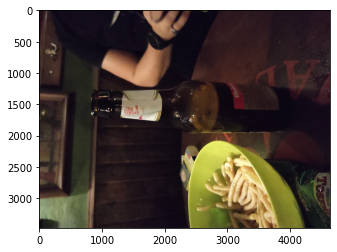

In [38]:
test_img_path = f'{validation_dir_mahou}/{random.choice(validation_files_mahou)}'
img = mpimg.imread(test_img_path)
plt.imshow(img)

Cargamos la imagen para meterla en la red neuronal

In [39]:
test_img = image.load_img(test_img_path, target_size=(150,150))
x = image.img_to_array(test_img)
x = np.expand_dims(x, axis=0)
cnn_input_image = np.vstack([x])

In [35]:
result = model.predict(cnn_input_image, batch_size=10)
result

1/1 [==============================] - 0s 34ms/step


array([[1., 0., 0.]], dtype=float32)

In [40]:
mappings = {
    0: 'alambra'
    , 1: 'coronita'
    , 2: 'mahou'
}
normalize_result = lambda result, mappings: mappings[np.argmax(result)]
result = normalize_result(result, mappings)
print(f'La imagen contiene una cerveza {result}')

La imagen contiene una cerveza alambra


# Exportar modelo

Se exporta el modelo a formato pickle para ser usado en el api

In [37]:
model.save(f'{base_dir}/model')